## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Utilities
import warnings
import pickle
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Dataset

In [2]:
# Load the raw dataset
df = pd.read_csv('../data/s11.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of matches: {len(df)}")
df.head()

Dataset shape: (2901, 14)
Number of matches: 2901


,result,server,team_1__001,team_1__002,team_1__003,team_1__004,team_1__005,team_2__001,team_2__002,team_2__003,team_2__004,team_2__005,timestamp,game_length
0,Defeat,eune,Irelia,Elise,Fizz,Draven,Morgana,Kayle,Rek'Sai,Yasuo,Ezreal,Thresh,2020-11-07 05:46:02,18m 0s
1,Victory,na,Gragas,Taliyah,Yone,Miss Fortune,Leona,Ornn,Kindred,Akali,Seraphine,Thresh,2020-12-31 08:45:22,30m 44s
2,Defeat,na,Volibear,Graves,Lulu,Lucian,Nami,Jax,Taliyah,Katarina,Kai'Sa,Sett,2020-12-31 07:12:07,30m 44s
3,Victory,na,Gragas,Sejuani,Yone,Samira,Leona,Sylas,Olaf,Anivia,Lucian,Galio,2020-12-31 06:12:52,30m 44s
4,Victory,na,Katarina,Kindred,Sylas,Yone,Galio,Gragas,Graves,Malphite,Samira,Thresh,2020-12-31 05:12:43,30m 44s


## 3. Data Quality Checks

In [3]:
# Check for missing values
print("=== Missing Values ===")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ No missing values found")

# Check for duplicates
print(f"\n=== Duplicates ===")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df = df.drop_duplicates()
    print(f"✓ New dataset shape: {df.shape}")
else:
    print("✓ No duplicates found")

=== Missing Values ===
✓ No missing values found

=== Duplicates ===
Number of duplicate rows: 45
Removing 45 duplicate rows...
✓ New dataset shape: (2856, 14)


In [4]:
# Check for inconsistencies in champion names
print("=== Champion Name Consistency ===")

team1_cols = [col for col in df.columns if col.startswith('team_1__')]
team2_cols = [col for col in df.columns if col.startswith('team_2__')]

# Get all unique champions
all_champions = set()
for col in team1_cols + team2_cols:
    all_champions.update(df[col].dropna().unique())

print(f"Total unique champions: {len(all_champions)}")
print(f"\nSample champion names:")
print(list(sorted(all_champions))[:20])

=== Champion Name Consistency ===
Total unique champions: 153

Sample champion names:
['Aatrox', 'Ahri', 'Akali', 'Alistar', 'Amumu', 'Anivia', 'Annie', 'Aphelios', 'Ashe', 'Aurelion Sol', 'Azir', 'Bard', 'Blitzcrank', 'Brand', 'Braum', 'Caitlyn', 'Camille', 'Cassiopeia', "Cho'Gath", 'Corki']


## 4. Data Restructuring

Transform the dataset to have one row per team (instead of one row per match)

In [5]:
# Create a dataset with one row per team
# Each match will generate 2 rows: Team 1 and Team 2

def create_team_dataset(df):
    """
    Transform match data into team data.
    Each match creates 2 rows (one per team) with:
    - 5 champion picks
    - 5 enemy champion picks
    - Binary outcome (1 = win, 0 = loss)
    """
    
    team_data = []
    
    for idx, row in df.iterrows():
        # Team 1 data
        team1_champions = [row[f'team_1__{i:03d}'] for i in range(1, 6)]
        team2_champions = [row[f'team_2__{i:03d}'] for i in range(1, 6)]
        
        # Team 1 row
        team1_row = {
            'champion_1': team1_champions[0],
            'champion_2': team1_champions[1],
            'champion_3': team1_champions[2],
            'champion_4': team1_champions[3],
            'champion_5': team1_champions[4],
            'enemy_1': team2_champions[0],
            'enemy_2': team2_champions[1],
            'enemy_3': team2_champions[2],
            'enemy_4': team2_champions[3],
            'enemy_5': team2_champions[4],
            'win': 1 if row['result'] == 'Victory' else 0
        }
        team_data.append(team1_row)
        
        # Team 2 row (inverted result)
        team2_row = {
            'champion_1': team2_champions[0],
            'champion_2': team2_champions[1],
            'champion_3': team2_champions[2],
            'champion_4': team2_champions[3],
            'champion_5': team2_champions[4],
            'enemy_1': team1_champions[0],
            'enemy_2': team1_champions[1],
            'enemy_3': team1_champions[2],
            'enemy_4': team1_champions[3],
            'enemy_5': team1_champions[4],
            'win': 0 if row['result'] == 'Victory' else 1
        }
        team_data.append(team2_row)
    
    return pd.DataFrame(team_data)

# Create team-based dataset
team_df = create_team_dataset(df)

print(f"Original matches: {len(df)}")
print(f"Team examples: {len(team_df)}")
print(f"Expected: {len(df) * 2}")
print(f"\nWin distribution:")
print(team_df['win'].value_counts())
print(f"\nSample rows:")
team_df.head(10)

Original matches: 2856
Team examples: 5712
Expected: 5712

Win distribution:
win
0    2856
1    2856
Name: count, dtype: int64

Sample rows:


,champion_1,champion_2,champion_3,champion_4,champion_5,enemy_1,enemy_2,enemy_3,enemy_4,enemy_5,win
0,Irelia,Elise,Fizz,Draven,Morgana,Kayle,Rek'Sai,Yasuo,Ezreal,Thresh,0
1,Kayle,Rek'Sai,Yasuo,Ezreal,Thresh,Irelia,Elise,Fizz,Draven,Morgana,1
2,Gragas,Taliyah,Yone,Miss Fortune,Leona,Ornn,Kindred,Akali,Seraphine,Thresh,1
3,Ornn,Kindred,Akali,Seraphine,Thresh,Gragas,Taliyah,Yone,Miss Fortune,Leona,0
4,Volibear,Graves,Lulu,Lucian,Nami,Jax,Taliyah,Katarina,Kai'Sa,Sett,0
5,Jax,Taliyah,Katarina,Kai'Sa,Sett,Volibear,Graves,Lulu,Lucian,Nami,1
6,Gragas,Sejuani,Yone,Samira,Leona,Sylas,Olaf,Anivia,Lucian,Galio,1
7,Sylas,Olaf,Anivia,Lucian,Galio,Gragas,Sejuani,Yone,Samira,Leona,0
8,Katarina,Kindred,Sylas,Yone,Galio,Gragas,Graves,Malphite,Samira,Thresh,1
9,Gragas,Graves,Malphite,Samira,Thresh,Katarina,Kindred,Sylas,Yone,Galio,0


## 5. Champion Encoding

Convert champion names to numerical values

In [6]:
# Create a champion encoder
all_champions_list = sorted(list(all_champions))
champion_to_id = {champion: idx for idx, champion in enumerate(all_champions_list)}
id_to_champion = {idx: champion for champion, idx in champion_to_id.items()}

print(f"Total champions to encode: {len(champion_to_id)}")
print(f"\nFirst 10 champion encodings:")
for i, (champ, idx) in enumerate(list(champion_to_id.items())[:10]):
    print(f"  {champ}: {idx}")

# Save the encoder for later use
with open('../data/champion_encoder.pkl', 'wb') as f:
    pickle.dump({'champion_to_id': champion_to_id, 'id_to_champion': id_to_champion}, f)
print("\n✓ Champion encoder saved to '../data/champion_encoder.pkl'")

Total champions to encode: 153

First 10 champion encodings:
  Aatrox: 0
  Ahri: 1
  Akali: 2
  Alistar: 3
  Amumu: 4
  Anivia: 5
  Annie: 6
  Aphelios: 7
  Ashe: 8
  Aurelion Sol: 9

✓ Champion encoder saved to '../data/champion_encoder.pkl'


In [7]:
# Apply encoding to the dataset
champion_cols = [f'champion_{i}' for i in range(1, 6)]
enemy_cols = [f'enemy_{i}' for i in range(1, 6)]

# Encode champions
for col in champion_cols + enemy_cols:
    team_df[col] = team_df[col].map(champion_to_id)

print("Champion encoding applied!")
print("\nEncoded dataset sample:")
team_df.head()

Champion encoding applied!

Encoded dataset sample:


,champion_1,champion_2,champion_3,champion_4,champion_5,enemy_1,enemy_2,enemy_3,enemy_4,enemy_5,win
0,40,25,30,23,75,54,93,143,27,122,0
1,54,93,143,27,122,40,25,30,23,75,1
2,35,118,144,73,63,85,58,2,103,122,1
3,85,58,2,103,122,35,118,144,73,63,0
4,137,36,67,66,76,44,118,53,48,104,0


## 6. Feature Engineering - One-Hot Encoding Approach

Create binary features for each champion (present/absent in team)

In [8]:
# Create one-hot encoded features for team composition
def create_onehot_features(team_df, champion_to_id):
    """
    Create one-hot encoded features:
    - team_X: binary feature for each champion in team
    - enemy_X: binary feature for each champion in enemy team
    """
    
    n_champions = len(champion_to_id)
    n_samples = len(team_df)
    
    # Initialize arrays
    team_features = np.zeros((n_samples, n_champions), dtype=int)
    enemy_features = np.zeros((n_samples, n_champions), dtype=int)
    
    # Fill in the features
    for i in range(n_samples):
        # Team champions
        for j in range(1, 6):
            champ_id = team_df.iloc[i][f'champion_{j}']
            if not pd.isna(champ_id):
                team_features[i, int(champ_id)] = 1
        
        # Enemy champions
        for j in range(1, 6):
            champ_id = team_df.iloc[i][f'enemy_{j}']
            if not pd.isna(champ_id):
                enemy_features[i, int(champ_id)] = 1
    
    # Create column names
    team_cols = [f'team_{champion}' for champion in sorted(champion_to_id.keys())]
    enemy_cols = [f'enemy_{champion}' for champion in sorted(champion_to_id.keys())]
    
    # Create DataFrames
    team_df_onehot = pd.DataFrame(team_features, columns=team_cols)
    enemy_df_onehot = pd.DataFrame(enemy_features, columns=enemy_cols)
    
    return team_df_onehot, enemy_df_onehot

print("Creating one-hot encoded features...")
team_onehot, enemy_onehot = create_onehot_features(team_df, champion_to_id)

print(f"Team features shape: {team_onehot.shape}")
print(f"Enemy features shape: {enemy_onehot.shape}")
print(f"\nTotal features: {team_onehot.shape[1] + enemy_onehot.shape[1]}")

Creating one-hot encoded features...
Team features shape: (5712, 153)
Enemy features shape: (5712, 153)

Total features: 306


In [9]:
# Combine all features
X = pd.concat([team_onehot, enemy_onehot], axis=1)
y = team_df['win'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nTarget distribution:")
print(f"  Wins: {np.sum(y)} ({np.mean(y)*100:.1f}%)")
print(f"  Losses: {len(y) - np.sum(y)} ({(1-np.mean(y))*100:.1f}%)")

Feature matrix shape: (5712, 306)
Target vector shape: (5712,)

Target distribution:
  Wins: 2856 (50.0%)
  Losses: 2856 (50.0%)


## 7. Train-Test Split

In [10]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintain class balance
)

print("=== Train-Test Split ===")
print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining set class distribution:")
print(f"  Wins: {np.sum(y_train)} ({np.mean(y_train)*100:.1f}%)")
print(f"  Losses: {len(y_train) - np.sum(y_train)} ({(1-np.mean(y_train))*100:.1f}%)")
print(f"\nTest set class distribution:")
print(f"  Wins: {np.sum(y_test)} ({np.mean(y_test)*100:.1f}%)")
print(f"  Losses: {len(y_test) - np.sum(y_test)} ({(1-np.mean(y_test))*100:.1f}%)")

=== Train-Test Split ===
Training set size: 4569 (80.0%)
Test set size: 1143 (20.0%)

Training set class distribution:
  Wins: 2285 (50.0%)
  Losses: 2284 (50.0%)

Test set class distribution:
  Wins: 571 (50.0%)
  Losses: 572 (50.0%)


## 8. Alternative Feature Engineering - Statistical Features

Create additional features based on champion statistics

In [11]:
# Load champion statistics from exploration phase
try:
    champion_stats = pd.read_csv('../data/champion_statistics.csv', index_col=0)
    print("Champion statistics loaded successfully!")
    print(f"\nStatistics available for {len(champion_stats)} champions")
    print("\nColumns:")
    print(champion_stats.columns.tolist())
    champion_stats.head()
except:
    print("⚠ Champion statistics not found. Run 01_data_exploration.ipynb first.")
    champion_stats = None

Champion statistics loaded successfully!

Statistics available for 153 champions

Columns:
['Total_Games', 'Wins', 'Win_Rate_%']


In [12]:
# Create statistical features if stats are available
if champion_stats is not None:
    def create_stat_features(team_df, champion_stats, id_to_champion):
        """
        Create statistical features:
        - Average win rate of team
        - Average win rate of enemy team
        - Total games played by team champions
        - Win rate differential
        """
        
        features = []
        
        for idx, row in team_df.iterrows():
            team_winrates = []
            enemy_winrates = []
            team_games = []
            enemy_games = []
            
            # Team statistics
            for i in range(1, 6):
                champ_id = row[f'champion_{i}']
                if not pd.isna(champ_id):
                    champ_name = id_to_champion[int(champ_id)]
                    if champ_name in champion_stats.index:
                        team_winrates.append(champion_stats.loc[champ_name, 'Win_Rate_%'])
                        team_games.append(champion_stats.loc[champ_name, 'Total_Games'])
            
            # Enemy statistics
            for i in range(1, 6):
                champ_id = row[f'enemy_{i}']
                if not pd.isna(champ_id):
                    champ_name = id_to_champion[int(champ_id)]
                    if champ_name in champion_stats.index:
                        enemy_winrates.append(champion_stats.loc[champ_name, 'Win_Rate_%'])
                        enemy_games.append(champion_stats.loc[champ_name, 'Total_Games'])
            
            # Calculate features
            features.append({
                'team_avg_winrate': np.mean(team_winrates) if team_winrates else 50.0,
                'enemy_avg_winrate': np.mean(enemy_winrates) if enemy_winrates else 50.0,
                'team_total_games': np.sum(team_games) if team_games else 0,
                'enemy_total_games': np.sum(enemy_games) if enemy_games else 0,
                'winrate_differential': (np.mean(team_winrates) - np.mean(enemy_winrates)) if (team_winrates and enemy_winrates) else 0
            })
        
        return pd.DataFrame(features)
    
    print("Creating statistical features...")
    stat_features = create_stat_features(team_df, champion_stats, id_to_champion)
    print(f"Statistical features shape: {stat_features.shape}")
    print("\nFeature statistics:")
    print(stat_features.describe())
else:
    stat_features = None
    print("Skipping statistical features creation.")

Creating statistical features...
Statistical features shape: (5712, 5)

Feature statistics:
       team_avg_winrate  enemy_avg_winrate  team_total_games  \
count       5712.000000        5712.000000       5712.000000   
mean          50.002176          50.002176       2357.689251   
std            1.717095           1.717095        703.608065   
min           42.800573          42.800573        363.000000   
25%           48.931550          48.931550       1871.750000   
50%           49.971672          49.971672       2367.500000   
75%           50.972350          50.972350       2863.000000   
max           59.606831          59.606831       4266.000000   

       enemy_total_games  winrate_differential  
count        5712.000000           5712.000000  
mean         2357.689251              0.000000  
std           703.608065              2.512623  
min           363.000000            -13.968330  
25%          1871.750000             -1.615173  
50%          2367.500000             

## 9. Save Preprocessed Data

In [13]:
# Save processed data
print("Saving preprocessed data...")

# Save train-test splits
np.save('../data/X_train.npy', X_train.values)
np.save('../data/X_test.npy', X_test.values)
np.save('../data/y_train.npy', y_train)
np.save('../data/y_test.npy', y_test)
print("✓ Train-test splits saved")

# Save feature names
feature_names = X.columns.tolist()
with open('../data/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("✓ Feature names saved")

# Save team dataframe with encoded champions
team_df.to_csv('../data/team_dataset.csv', index=False)
print("✓ Team dataset saved")

# Save statistical features if created
if stat_features is not None:
    stat_features.to_csv('../data/statistical_features.csv', index=False)
    print("✓ Statistical features saved")

print("\n" + "="*60)
print("PREPROCESSING COMPLETE!")
print("="*60)
print(f"\n📊 Dataset Summary:")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Test samples: {len(X_test):,}")
print(f"   • Total features: {X.shape[1]:,}")
print(f"   • Unique champions: {len(champion_to_id)}")
print(f"\n✓ Ready for model training!")
print(f"\n📋 Next step: Run 03_baseline_models.ipynb")

Saving preprocessed data...
✓ Train-test splits saved
✓ Feature names saved
✓ Team dataset saved
✓ Statistical features saved

PREPROCESSING COMPLETE!

📊 Dataset Summary:
   • Training samples: 4,569
   • Test samples: 1,143
   • Total features: 306
   • Unique champions: 153

✓ Ready for model training!

📋 Next step: Run 03_baseline_models.ipynb


## 10. Data Visualization Summary

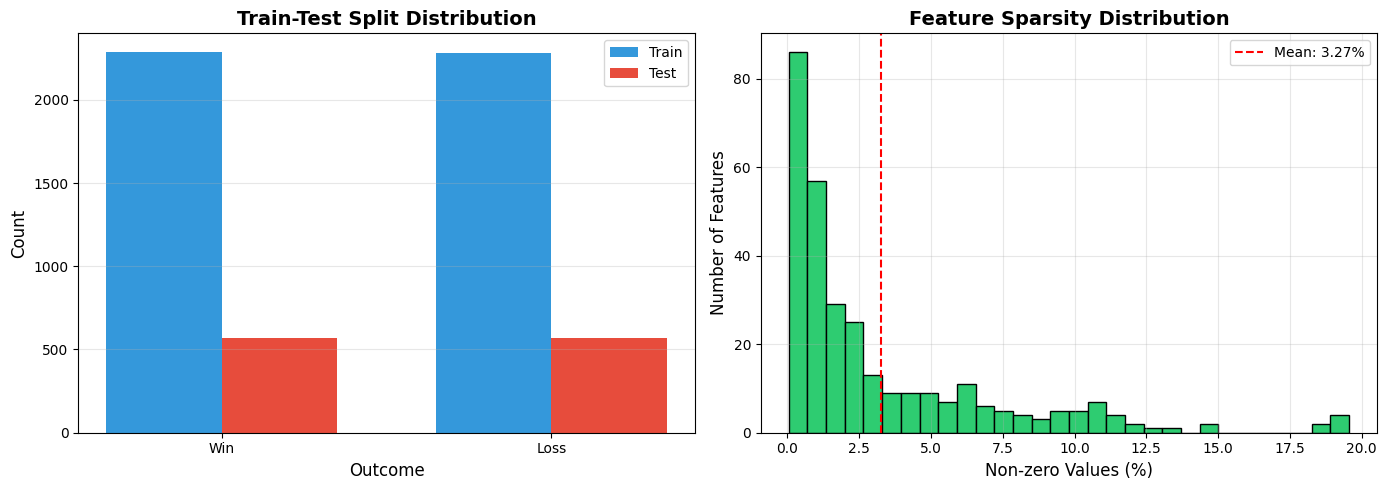

✓ Visualization saved to '../reports/figures/preprocessing_summary.png'


In [14]:
# Visualize the preprocessed data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train-test split visualization
split_data = pd.DataFrame({
    'Dataset': ['Train', 'Train', 'Test', 'Test'],
    'Outcome': ['Win', 'Loss', 'Win', 'Loss'],
    'Count': [np.sum(y_train), len(y_train)-np.sum(y_train), 
              np.sum(y_test), len(y_test)-np.sum(y_test)]
})

train_data = split_data[split_data['Dataset'] == 'Train']
test_data = split_data[split_data['Dataset'] == 'Test']

x = np.arange(2)
width = 0.35

axes[0].bar(x - width/2, train_data['Count'].values, width, label='Train', color='#3498db')
axes[0].bar(x + width/2, test_data['Count'].values, width, label='Test', color='#e74c3c')
axes[0].set_xlabel('Outcome', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Train-Test Split Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Win', 'Loss'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Feature sparsity (percentage of non-zero values)
sparsity = (X_train != 0).mean(axis=0)
axes[1].hist(sparsity * 100, bins=30, color='#2ecc71', edgecolor='black')
axes[1].set_xlabel('Non-zero Values (%)', fontsize=12)
axes[1].set_ylabel('Number of Features', fontsize=12)
axes[1].set_title('Feature Sparsity Distribution', fontsize=14, fontweight='bold')
axes[1].axvline(sparsity.mean() * 100, color='red', linestyle='--', 
                label=f'Mean: {sparsity.mean()*100:.2f}%')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/preprocessing_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to '../reports/figures/preprocessing_summary.png'")